**Run celltype quality control and annotation I**

In [1]:
# load libraries
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt
from tqdm.notebook import tqdm
from numba.typed import Dict
from scipy import sparse
import seaborn as sns
from scipy import stats

from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts, log_normalize_counts, get_fraction_mito, filter_cells_by_mito

from ABCA7lof2.annotation import get_major_annotations
from ABCA7lof2.singlecell import bulk_data, expressed_fraction

config.THREADING_LAYER = 'workqueue'

#### Load data & define paths

In [2]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'

# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


#### Run initial cell filtering

In [3]:
# run initial cell filtering
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, 1, 500, 10000, plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf'), 'MT-', './processed_data/single_cell')

getting mito fractions
searching for best params
gaussian gridsearch
Number of components               5
Type of covariance         spherical
BIC score               64229.470919
Name: 4, dtype: object
All cells
150456
Mito keep
0.8855213484340937


  0%|          | 0/150456 [00:00<?, ?it/s]

All keep:
0.8675626096666135
Mito fraction mean discard:
0.19015335152011015
Mito fraction mean keep:
0.01417689282567818


  0%|          | 0/130530 [00:00<?, ?it/s]

#### Do PCA

In [4]:
# run PCA
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations('./processed_data/single_cell/brain_marker_genes.csv', features[:,0], filtered_counts, total_counts, 1, 50, 10, './processed_data/single_cell', None)

using prior markers for reduction & annotation...
getting marker indices...
getting normalized marker matrix...


  0%|          | 0/130530 [00:00<?, ?it/s]

running pca...
estimating gaussian mixture model...
gaussian gridsearch
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START covariance_type=full, n_components=11......................
[CV 1/5; 1/20] END covariance_type=full, n_components=11;, score=-2851679.070 total time=  31.8s
[CV 2/5; 1/20] START covariance_type=full, n_components=11......................
[CV 2/5; 1/20] END covariance_type=full, n_components=11;, score=-2826263.628 total time= 1.0min
[CV 3/5; 1/20] START covariance_type=full, n_components=11......................
[CV 3/5; 1/20] END covariance_type=full, n_components=11;, score=-2820802.996 total time=  29.9s
[CV 4/5; 1/20] START covariance_type=full, n_components=11......................
[CV 4/5; 1/20] END covariance_type=full, n_components=11;, score=-2853716.301 total time=  25.6s
[CV 5/5; 1/20] START covariance_type=full, n_components=11......................
[CV 5/5; 1/20] END covariance_type=full, n_components=11;, score=-2826367

#### Plot liklihood distributions by cluster and remove clusters with very low liklihoods

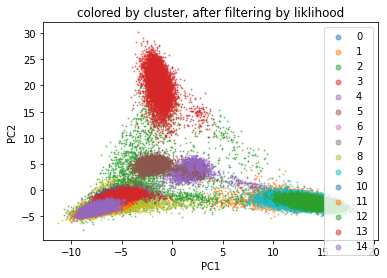

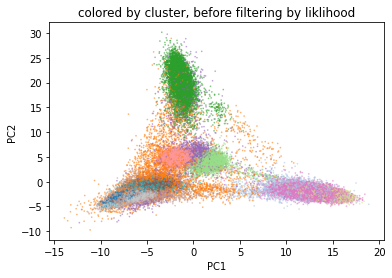

Text(0, 0.5, 'PC2')

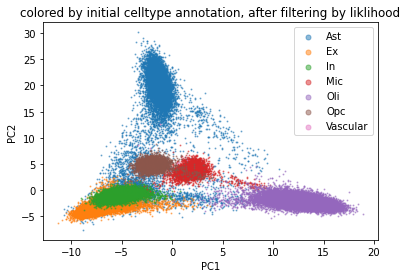

In [5]:
# plot cluster annotations and temporary celltype annos
index = scores>-100
for i in np.unique(predict):
    plt.pyplot.scatter(projected_matrix[index&(predict==i),0], projected_matrix[index&(predict==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)
plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')
plt.pyplot.title('colored by cluster, after filtering by liklihood')
plt.pyplot.show()

plt.pyplot.scatter(projected_matrix[:,0], projected_matrix[:,1], s=.5, alpha=0.5, c=predict,cmap='tab20')
plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')
plt.pyplot.title('colored by cluster, before filtering by liklihood')

plt.pyplot.show()

for i in np.unique(annotations):
    plt.pyplot.scatter(projected_matrix[index&(annotations==i),0], projected_matrix[index&(annotations==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')

plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')

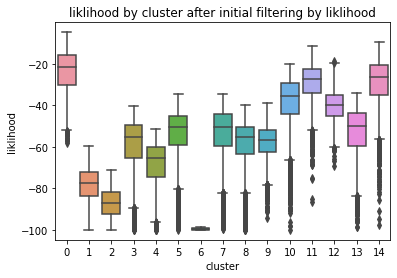

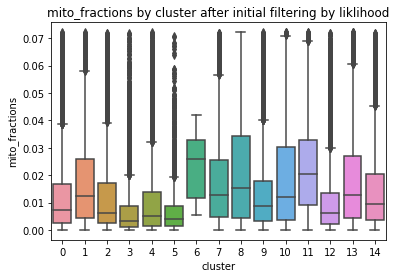

In [6]:
# plot liklihood by cluster
sns.boxplot(x=predict[index], y=scores[index])
plt.pyplot.xlabel('cluster')
plt.pyplot.ylabel('liklihood')
plt.pyplot.title('liklihood by cluster after initial filtering by liklihood')
plt.pyplot.show()
sns.boxplot(x=predict[index], y=mito_fractions[index])
plt.pyplot.xlabel('cluster')
plt.pyplot.ylabel('mito_fractions')
plt.pyplot.title('mito_fractions by cluster after initial filtering by liklihood')
plt.pyplot.show()

In [9]:
# remove clusters based on liklihood
index = index&(predict!=1)&(predict!=2)&(predict!=6)

Text(0, 0.5, 'PC2')

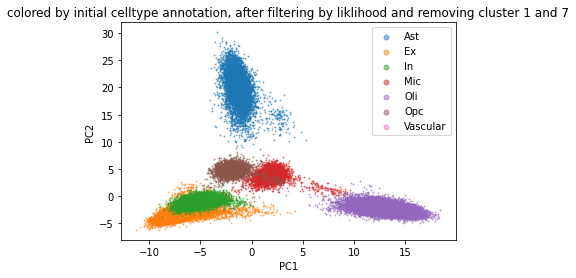

In [10]:
# plot cells after removing clusters 
for i in np.unique(annotations):
    plt.pyplot.scatter(projected_matrix[index&(annotations==i),0], projected_matrix[index&(annotations==i),1], s=1, alpha=.5, label=i)
plt.pyplot.legend( markerscale=5)

plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood and removing cluster 1 and 7')

plt.pyplot.xlabel('PC1')
plt.pyplot.ylabel('PC2')

#### Plots pre- and post-QC

In [11]:
# after this initial QC, how do cells that were kept vs discarded differ in terms of two key quality metrics; mito fraction and total counts
print('ttest mito fractions:', stats.ttest_ind(mito_fractions[index], mito_fractions[np.invert(index)]))
print('mean keep:', np.mean(mito_fractions[index]))
print('mean discard:', np.mean(mito_fractions[np.invert(index)]))

print('ttest total_counts:', stats.ttest_ind(total_counts[index], total_counts[np.invert(index)]))
print('mean keep:', np.mean(total_counts[index]))
print('mean discard:', np.mean(total_counts[np.invert(index)]))

ttest mito fractions: Ttest_indResult(statistic=-17.356783855284224, pvalue=2.087298169749318e-67)
mean keep: 0.013925053060006697
mean discard: 0.016337724224270784
ttest total_counts: Ttest_indResult(statistic=86.49116603964892, pvalue=0.0)
mean keep: 11532.78329412771
mean discard: 2645.426495412844


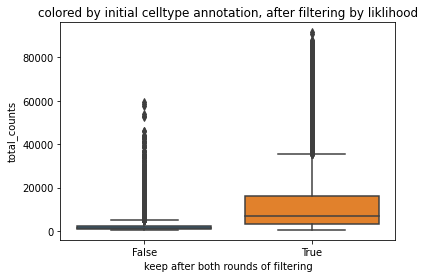

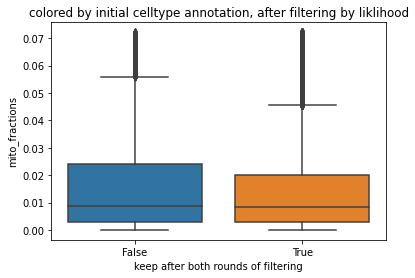

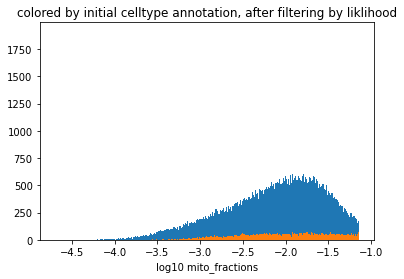

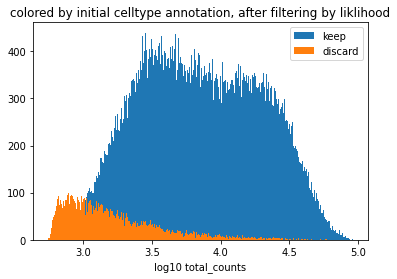

In [12]:
# plot distributions of mito fractions and total counts pre and post filtering
sns.boxplot(x=index, y=total_counts)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('keep after both rounds of filtering')
plt.pyplot.ylabel('total_counts')
plt.pyplot.show()

sns.boxplot(x=index, y=mito_fractions)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('keep after both rounds of filtering')
plt.pyplot.ylabel('mito_fractions')
plt.pyplot.show()

plt.pyplot.hist(np.log10(mito_fractions[index]+2e-5), 500)
plt.pyplot.hist(np.log10(mito_fractions[np.invert(index)]+2e-5), 500)
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('log10 mito_fractions')
None
plt.pyplot.show()


plt.pyplot.hist(np.log10(total_counts[index]+2e-5), 500, label='keep')
plt.pyplot.hist(np.log10(total_counts[np.invert(index)]+2e-5), 500, label='discard')
plt.pyplot.legend()
plt.pyplot.title('colored by initial celltype annotation, after filtering by liklihood')
plt.pyplot.xlabel('log10 total_counts')
None
plt.pyplot.show()


In [13]:
# how many cells were removed in total by this filtering?
counts.shape[0]-filtered_counts.shape[0]

19926

In [14]:
# plot n cells before filtering
np.unique(annotations, return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Vascular'], dtype='<U8'),
 array([14449, 48155, 16678,  6413, 35781,  6148,  2906]))

In [15]:
# plot n cells after filtering
np.unique(annotations[index], return_counts=True)

(array(['Ast', 'Ex', 'In', 'Mic', 'Oli', 'Opc'], dtype='<U8'),
 array([ 8203, 48098, 16651,  5982, 31907,  6064]))

#### Compile & save all the data

In [16]:
# compile metadata
filtered_meta_final = np.concatenate((filtered_meta, index.reshape(-1,1),  predict.reshape(-1,1),scores.reshape(-1,1),  annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((np.concatenate((np.array(['barcodes','index']), meta_col_names), axis=0), np.array(('keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)

# save data
np.save('./processed_data/single_cell/filtered_meta.npy', filtered_meta_final)
np.save('./processed_data/single_cell/meta_names.npy', meta_names)
np.save('./processed_data/single_cell/features.npy', features)
np.save('./processed_data/single_cell/projected_matrix.npy', projected_matrix)
np.save('./processed_data/single_cell/marker_indices.npy', marker_indices)

# save genes that are being considered based on criteria
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 130530/130530 [02:47<00:00, 779.57it/s]


In [17]:
# save genes that are being considered based on criteria
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 130530/130530 [02:49<00:00, 768.49it/s]


In [22]:
# save protein coding index
g = pd.read_csv('./raw_data/ensembl.GRCh38p12.genes.complete.annot.csv')
genes = set(g['Gene.stable.ID'][(g['Gene.type']=='protein_coding')&(g['Chromosome.scaffold.name']!='MT')])
p_index = [x in genes for x in features[:,1]]
features_temp = features[p_index]
np.save('./processed_data/single_cell/features_proteincoding_index.npy', p_index)
